# Summary

This note book is going to create box plots for rural and non rural areas in each province for upload and download speeds, averaged throughout time.


In [4]:
import sys
sys.path.append("..")

In [5]:
import src.config

In [6]:
from src.datasets.loading import statcan, ookla

In [50]:
import numpy as np 
import pandas as pd
import geopandas as gp
import os
import plotly.graph_objects as go
import plotly.express as px

In [9]:
import matplotlib.pyplot as plt 

## Load 
Load some of the available data. The census population data and StatCan boundaries are automatically loaded from 
the StatCan website. The overlays and tile geometries/speeds need to pre-computed and saved to the overlays directory and data directories. 

### Load All Unique Tile Gemoetries

In [19]:
# the following is a geopandas datafarme of shape (670292, 2) 
ookla_tiles = ookla.canada_tiles()

In [8]:
ookla_tiles.head()

,quadkey,geometry
0,302303331012303,"POLYGON ((-73.36121 45.53329, -73.35571 45.533..."
1,212122230130321,"POLYGON ((-122.75574 49.30364, -122.75024 49.3..."
2,212120311013031,"POLYGON ((-121.14075 51.58390, -121.13525 51.5..."
3,212102012132221,"POLYGON ((-122.77771 53.85901, -122.77222 53.8..."
4,212122232013120,"POLYGON ((-122.89307 49.11703, -122.88757 49.1..."


### Load Census Population Information

In [20]:
# a pandas dataframe containting 3 columns
da_pops = statcan.dissemination_areas_populations()

In [21]:
da_pops.head()

,DAUID,GEO_NAME,DAPOP
508,10010734,10010734,150.0
762,10010735,10010735,350.0
889,10010736,10010736,130.0
1143,10010733,10010733,65.0
1397,10010737,10010737,365.0


### Labelling Tiles
Generate labels from geometric overlay of the Ookla tiles and Statistics Canada Dissemination Areas (DA). 
Label each tile with the information from the StatCan areas based on which DA the tile overlaps the most with.

In [22]:
o = gp.read_file(src.config.OVERLAYS_DIR / 'tile_das_overlay') #this can take a few minutes to load.
tile_da_label = o.dropna(subset=['DAUID','quadkey']).sort_values(by=['quadkey','tile_frac'],ascending=False).drop_duplicates(subset='quadkey', keep='first')
tile_da_label['quadkey'] = tile_da_label['quadkey'].astype(int)
tile_da_label['DAUID'] = tile_da_label['DAUID'].astype(int)

In [23]:
tile_da_label.columns

Index(['DAUID', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME', 'CDTYPE', 'CCSUID',
       'CCSNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'ERUID', 'ERNAME', 'SACCODE',
       'SACTYPE', 'CMAUID', 'CMAPUID', 'CMANAME', 'CMATYPE', 'CTUID', 'CTNAME',
       'ADAUID', 'das_area', 'quadkey', 'tile_area', 'tile_frac', 'das_frac',
       'geometry'],
      dtype='object')

In [12]:
tile_da_label.head()

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,CMATYPE,CTUID,CTNAME,ADAUID,das_area,quadkey,tile_area,tile_frac,das_frac,geometry
986447,62080028,62,Nunavut,6208,Kitikmeot,REG,6208098,"Kitikmeot, Unorganized",6208081,Gjoa Haven,...,NaN,NaN,NaN,62080005,3.611392e+06,33321111030011,47209.300113,1.000000,0.013072,"POLYGON ((6041822.741 3571239.252, 6041809.093..."
986443,62080028,62,Nunavut,6208,Kitikmeot,REG,6208098,"Kitikmeot, Unorganized",6208081,Gjoa Haven,...,NaN,NaN,NaN,62080005,3.611392e+06,33321111012233,47201.161453,0.506432,0.006619,"POLYGON ((6041651.609 3571328.671, 6041669.834..."
986446,62080027,62,Nunavut,6208,Kitikmeot,REG,6208098,"Kitikmeot, Unorganized",6208081,Gjoa Haven,...,NaN,NaN,NaN,62080005,2.770787e+07,33321111012232,47201.161454,0.586428,0.000999,"POLYGON ((6041569.680 3571359.606, 6041461.349..."
1004929,62080027,62,Nunavut,6208,Kitikmeot,REG,6208098,"Kitikmeot, Unorganized",6208081,Gjoa Haven,...,NaN,NaN,NaN,62080005,2.770787e+07,33321111012231,47193.024198,1.000000,0.001703,"POLYGON ((6041850.036 3571672.697, 6041836.389..."
1004930,62080027,62,Nunavut,6208,Kitikmeot,REG,6208098,"Kitikmeot, Unorganized",6208081,Gjoa Haven,...,NaN,NaN,NaN,62080005,2.770787e+07,33321111012223,47201.161454,0.906848,0.001545,"POLYGON ((6041224.366 3571429.663, 6041224.610..."


### Saving the CSVs so far

In [19]:
def save_df(dataframe, df_type:str, base_path: str, file_name: str):
    
    full_path = os.path.join(base_path, file_name)
    if df_type == "pd":
        dataframe.to_csv(full_path, header=True)
    elif df_type == "gp":
        dataframe.to_file(full_path, driver='GPKG')
    return

In [30]:
# saving the csv files
path_to_files = "../data/dataframes/"
save_df(ookla_tiles, df_type="gp",base_path=path_to_files, file_name="ookla_tiles.gpkg")
save_df(da_pops, df_type="pd", base_path=path_to_files, file_name="da_pops.csv")
save_df(tile_da_label, df_type="gp", base_path=path_to_files, file_name="tile_da_label.gpkg")


### Loading in the csv files for faster runtime

In [2]:
def load_csv_file(df_type:str, base_path: str, file_name:str):
    """
    load in the dataframe whether pandas or geopandas
    """
    
    full_path = os.path.join(base_path, file_name)
    if df_type == "pd":
        result = pd.read_csv(full_path)
    elif df_type == "gp":
        result = gp.read_file(full_path)
    return result
    

In [8]:
path_to_files = "../data/dataframes/"
ookla_tiles = load_csv_file(df_type="gp", base_path=path_to_files, file_name="ookla_tiles.gpkg")
print("ookla loaded")
da_pops = load_csv_file(df_type="pd", base_path=path_to_files, file_name="da_pops.csv")
print("da pops loaded")
tile_da_label = load_csv_file(df_type="gp", base_path=path_to_files, file_name="tile_da_label.gpkg")
print("tile da label loaded")

ookla loaded
da pops loaded
tile da label loaded


### Speed Test Data
Load in the previous 4 quarters of data. Since we're currently in Q3 of 2022, the most recent quarter is Q2 
so we can slice the files listed to grab those. Subsequently, we'll calculate weighted averages for individual tiles and use those as representative speeds for our model.

In [11]:
def get_speed_data_from_to(from_date:tuple, to_date:tuple):
    """
    Getting speed data inclusive from some date to some other date.
    """
    # get all data from starting time to ending time
    data_subset = ookla.speed_data(ookla.available_files().loc[from_date:to_date].path)
    # averaging speed test data over time over region
    down = data_subset.groupby('quadkey').apply(lambda s:np.average(s.avg_d_kbps, weights=s.tests)).rename('avg_d_kbps')
    up = data_subset.groupby('quadkey').apply(lambda s:np.average(s.avg_u_kbps, weights=s.tests)).rename('avg_u_kbps')
    tests = data_subset.groupby('quadkey')['tests'].sum()
    devices = data_subset.groupby('quadkey')['devices'].sum()
    averaged_over_region = pd.concat([down, up, tests, devices],axis=1)
    return averaged_over_region

In [12]:
time_subset = get_speed_data_from_to(from_date=('fixed',2019,1), to_date=('fixed',2023,1))

In [13]:
time_subset.head()

,avg_d_kbps,avg_u_kbps,tests,devices
quadkey,,,,
13230212122122,544197.000000,269445.0,1,1
23313133202223,43221.000000,3756.0,2,1
23313133220001,29290.000000,2404.0,2,1
23313203322102,76875.000000,21079.0,2,1
23331133131232,2342.333333,1151.0,3,2


In [14]:
time_subset.shape

(615683, 4)

### Merge All The Data
It's a bit messy, but we're merging several tables and removing a few of the redundant or non-useful 
columns as we go through. At the end the `features_table` variable will have all of the 
tiles within census areas labelled by what type of Census Subdivision, Dissemination Area, Population Centre, etc. they are in, as well as population information for the DA (smallest area with populations available) and the speed test averages over the last 4 quarters.

In [15]:
## merge dissemination area (DA) populations with ookla tiles (already combined with other statcan data)
features_table = tile_da_label.merge(da_pops, on='DAUID', how='left')
features_table['DAPOP'] = features_table['DAPOP'].fillna(0).astype(int)
del features_table['GEO_NAME']
features_table = pd.DataFrame(features_table)
del features_table['geometry']
features_table['POP_DENSITY'] = features_table['DAPOP']/features_table['das_area']*1000**2 #people per square kilometer

# take all ookla tiles, merge the speeds data and tile labels and populations
features_table = ookla_tiles.merge(time_subset, on='quadkey').merge(features_table, on='quadkey')

# compute spatial joins to identify if area is a population centre
pop_info = statcan.boundary('population_centres').to_crs('epsg:4326')
pop_info = pop_info[['PCUID', 'PCNAME', 'PCTYPE', 'PCPUID', 'PCCLASS', 'geometry']] ##removes some redundant cols from DAs
features_table = features_table.sjoin(pop_info, how='left')
del features_table['index_right']
features_table = features_table.sort_values(by=['PCUID','quadkey']).drop_duplicates(subset=['quadkey']) #keep tiles where overlap was true

### Categorize All the Columns
All the columns from our joins above can be roughly split into categories based on the type of 
data and how you might use them in a simple supervised learning problem. These are broken down as follows:

In [16]:
pkey = 'quadkey'
geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE',] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'CMATYPE', 'PCTYPE', 'PCCLASS',
]
numerical_vars = [
    'tests', 'devices',
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]
target_vars = ['avg_d_kbps', 'avg_u_kbps']

In [17]:
col_subset = [pkey] + categorical_labels + numerical_vars + target_vars
features_table.loc[:,col_subset].set_index('quadkey')

,PRNAME,CDTYPE,CSDTYPE,SACTYPE,CMATYPE,PCTYPE,PCCLASS,tests,devices,das_area,tile_area,tile_frac,das_frac,DAPOP,POP_DENSITY,avg_d_kbps,avg_u_kbps
quadkey,,,,,,,,,,,,,,,,,
302231302213222,Ontario,RM,T,1,B,2,2,142,36,4.489387e+06,205331.876525,0.917314,0.041955,1420,316.301553,131957.809859,17415.246479
302231302213223,Ontario,RM,T,1,B,2,2,18,11,2.309252e+07,205331.876525,0.475620,0.004229,470,20.352909,130224.055556,55252.222222
302231302230013,Ontario,RM,T,1,B,2,2,80,29,5.391016e+06,205402.379648,0.894827,0.034094,1030,191.058601,275870.087500,126846.125000
302231302230022,Ontario,RM,T,1,B,2,2,69,10,1.030375e+07,205472.906899,0.611219,0.012189,505,49.011263,7741.492754,978.376812
302231302230023,Ontario,RM,T,1,B,2,2,438,53,1.765704e+06,205472.906900,0.871430,0.101407,795,450.245236,10936.929224,1343.034247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303303002111300,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,SNO,7,NaN,NaN,NaN,2,1,9.644073e+08,178641.754217,1.000000,0.000185,0,0.000000,21316.000000,1134.000000
303303002122000,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,7,NaN,NaN,NaN,5,2,1.194131e+06,179256.404038,0.574792,0.086285,150,125.614323,12788.600000,2904.200000
303303002122001,Newfoundland and Labrador / Terre-Neuve-et-Lab...,CDR,T,7,NaN,NaN,NaN,16,6,1.194131e+06,179256.404038,1.000000,0.150114,150,125.614323,39349.375000,9668.250000


In [18]:
type(features_table)

geopandas.geodataframe.GeoDataFrame

In [21]:
path_to_files = "../data/dataframes/"
save_df(features_table, df_type="gp", base_path=path_to_files, file_name="features_table.gpkg")

# Loading the Features Table Dataset

In [10]:
path_to_files = "../data/dataframes/"
features_table = load_csv_file(df_type="gp", base_path=path_to_files, file_name="features_table.gpkg")

### Inputs to the Program

The inputs to the program include:
- Name of Province
- Upload or Download
- Population Percentile (from 10 to 90)

In [11]:
province_names = features_table["PRNAME"].unique()
print(province_names)

['Ontario' 'Quebec / Québec' 'Alberta' 'Manitoba'
 'Nova Scotia / Nouvelle-Écosse' 'British Columbia / Colombie-Britannique'
 'Saskatchewan' 'New Brunswick / Nouveau-Brunswick'
 'Newfoundland and Labrador / Terre-Neuve-et-Labrador'
 'Prince Edward Island / Île-du-Prince-Édouard' 'Nunavut'
 'Northwest Territories / Territoires du Nord-Ouest' 'Yukon']


In [70]:
# creating the inputs to the program
province_name = "Alberta"

# used to filter by population density. Should be a number between 10 and 100.
low_percentile = 25
top_percentile = 75

In [71]:
def get_databaset_subset_province_percentile(database: gp.geodataframe.GeoDataFrame,
                                             province_name:str,
                                             top_percentile:int,
                                             low_percentile:int) -> gp.geodataframe.GeoDataFrame:
    """
    part of the database will be retured that exist in the "province_name" and exists in
    the low_percentile to top_percentile of the population density.
    
    returns: the subset of dataframe
    """
    province_dataset = database[database["PRNAME"] == province_name]
    low_bound = province_dataset["POP_DENSITY"].quantile(low_percentile * 0.01)
    top_bound = province_dataset["POP_DENSITY"].quantile(top_percentile * 0.01)
    target_dataset = province_dataset[(province_dataset["POP_DENSITY"] > low_bound)& \
                                      (province_dataset["POP_DENSITY"] < top_bound)]
    return target_dataset
    

In [72]:
filtered_features_table = get_databaset_subset_province_percentile(features_table,
                                                                  province_name=province_name,
                                                                  top_percentile=top_percentile,
                                                                  low_percentile=low_percentile)


In [73]:
filtered_features_table[["avg_u_kbps", "avg_d_kbps"]].describe()

,avg_u_kbps,avg_d_kbps
count,43224.000000,43224.000000
mean,10616.845061,33318.420467
std,26419.191210,49328.649401
min,1.000000,2.000000
25%,1521.000000,9364.000000
50%,3767.394737,18787.250000
75%,10011.568890,34194.500000
max,598982.000000,838523.000000


In [74]:
def get_filtered_download_and_upload_speeds(filtered_features_table, remove_outliers=False):
    """
    param:
    filtered_features_table -> Part of the whole dataset that is filtered based on province and population density
    
    return:
    The upload and download speeds after removing the outliers.
    """
    filtered_down_speed = filtered_features_table["avg_d_kbps"]
    filtered_up_speed = filtered_features_table["avg_u_kbps"]
    if remove_outliers:
        up_third_quartile = filtered_up_speed.quantile(0.75)
        down_third_quartile = filtered_up_speed.quantile(0.75)
    else:
        up_third_quartile = np.inf
        down_third_quartile = np.inf
    filtered_down_speed = filtered_down_speed[filtered_down_speed < down_third_quartile]
    filtered_up_speed = filtered_up_speed[filtered_up_speed < up_third_quartile]
    return filtered_down_speed, filtered_up_speed
    

In [75]:
filtered_down_speed, filtered_up_speed = get_filtered_download_and_upload_speeds(filtered_features_table, remove_outliers=False)

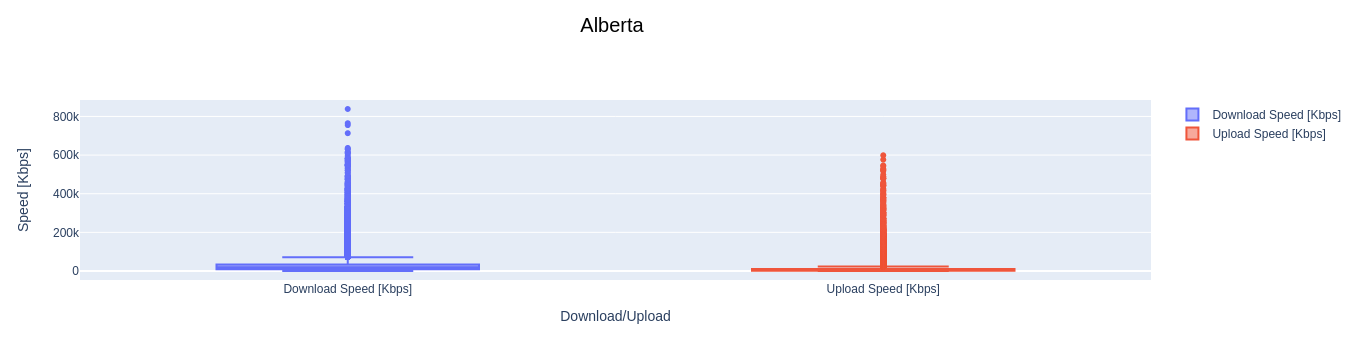

In [86]:
# Creating a plotly figure

fig = go.Figure()
fig.add_trace(go.Box(y=filtered_down_speed, name="Download Speed [Kbps]"))
fig.add_trace(go.Box(y=filtered_up_speed, name="Upload Speed [Kbps]"))
fig.update_layout(xaxis_title="Download/Upload", yaxis_title="Speed [Kbps]", 
    title={
        'text': 'Alberta',
        'y': 0.95,
        'x': 0.45,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
    })
fig.show()